In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import sys  
  
# The path you want to add  
path_to_add = r'C:\Users\elorberb\PycharmProjects\BGU projects\Advanced_NLP\DeltaPredictor'  
  
# Add the directory to sys.path  
sys.path.insert(0, path_to_add)


C:\Users\elorberb\AppData\Local\Temp\ipykernel_13456\123696342.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv("../data/test.csv")
df.drop('meta.success', axis=1, inplace=True)
# Iterate over the DataFrame and print the text of each record  
# for index, row in df.head(15).iterrows():  
#     print(f"Record {index}:\n{row['text']}, \nlabel: {row['label']}")  

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1972 non-null   object
 1   label   1972 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 30.9+ KB


In [24]:
import os  
from src import prompts
from src.langchain_utils import run_chain  
from langchain_openai import AzureChatOpenAI  
from langchain.prompts import PromptTemplate  
from langchain.chains import LLMChain  
from dotenv import load_dotenv  
import pandas as pd  
from sklearn.metrics import accuracy_score, precision_score, recall_score  
from tqdm import tqdm
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix, classification_report  
from sklearn.metrics import roc_curve, auc  
import numpy as np  
import itertools
from src import comments 
import re  


# Load environment variables  
load_dotenv() 
  
  
def initialize_model(azure_deployment, template, input_vars):  
    llm = AzureChatOpenAI(azure_deployment=azure_deployment)  
    prompt_template = PromptTemplate(input_variables=input_vars, template=template)  
    chain = LLMChain(llm=llm, prompt=prompt_template)  
    return chain


def clean_text(text, default=None):  
    # Use regular expression to find integers in the text  
    matches = re.findall(r'\d+', text)  
    if matches:  
        # Return the first integer found  
        return int(matches[0])  
    else:  
        # Return the default value if no integer is found  
        return default  
  
def predict_labels(chain, df, n, input_vars_values):  
    df_copy = df.copy()  
    df_copy['predicted_label'] = None  
  
    for i, row in tqdm(df.head(n).iterrows()):  
        comment = row['text']  
        input_vars_values['comment'] = comment  
        resp = chain(input_vars_values)  
        try:  
            # Clean the response text to extract integer  
            pred = clean_text(resp['text'], default=-1)  # Using -1 as the default value  
            df_copy.at[i, 'predicted_label'] = pred  
        except ValueError as e:  
            print(f"Error converting prediction to int for row {i}: {e}")  
            df_copy.at[i, 'predicted_label'] = None  # or some default value  
  
    return df_copy 
  
def calculate_metrics(df_copy, n):  
    true_labels = df_copy['label'].head(n).tolist()  
    predicted_labels = df_copy['predicted_label'].head(n).tolist()  
  
    accuracy = accuracy_score(true_labels, predicted_labels)  
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)  
    recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)  
  
    return accuracy, precision, recall  
  
def print_metrics(accuracy, precision, recall):  
    print(f"Accuracy: {accuracy}")  
    print(f"Precision: {precision}")  
    print(f"Recall: {recall}")  
  
  
def run_evaluation(df, azure_deployment_name, num_records, template_dict, input_vars, input_vars_values, verbose=False):  
    """
    Runs the evaluation for a given dataframe and input variables.
    :param df: The dataframe to evaluate.
    :param azure_deployment_name: The name of the Azure deployment.
    :param template_dict: The template dictionary.
    :param input_vars: The input variables.
    :param input_vars_values: The input variables values.
    :param num_records: The number of records to evaluate.
    :param verbose: Whether to print the metrics.
    :return: results: The results of the evaluation.
    """
    
    results = {'model': azure_deployment_name,
               'template_type': template_dict['template_type']}  # Dictionary to store all outputs  
  
    # Initialize the model with the specified parameters  
    chain = initialize_model(azure_deployment_name, template_dict['template_text'], input_vars)  
    if verbose:  
        print("Model initialized.")  
  
    # Predict labels for the specified number of records  
    df_copy = predict_labels(chain, df, num_records, input_vars_values)  
    true_labels = df_copy['label'].head(num_records).tolist()  
    predicted_labels = df_copy['predicted_label'].head(num_records).tolist()  
    results['true_labels'] = true_labels  
    results['predicted_labels'] = predicted_labels  
  
    if verbose:  
        print("Predictions made.")  
  
    # Calculate the evaluation metrics  
    accuracy, precision, recall = calculate_metrics(df_copy, num_records)  
    results['metrics'] = {  
        'accuracy': accuracy,  
        'precision': precision,  
        'recall': recall  
    }  
      
    if verbose:  
        print_metrics(accuracy, precision, recall)  
  
    return results   

In [25]:
def evaluate_each_results(true_labels, predicted_labels):  
    # Assuming your classes are string or integer  
    unique_classes = np.unique(true_labels)  
    n_classes = len(unique_classes)  
  
    # Convert unique_classes to an array of strings for plotting  
    class_names = unique_classes.astype(str)  
  
    # Calculate confusion matrix  
    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=unique_classes)  
  
    # Classification report using the converted class names  
    class_report = classification_report(true_labels, predicted_labels, target_names=class_names)  
  
    # Plot confusion matrix  
    plt.figure(figsize=(6, 4))  
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)  
    plt.title('Confusion Matrix')  
    plt.colorbar()  
    tick_marks = np.arange(n_classes)  
    plt.xticks(tick_marks, class_names, rotation=45)  
    plt.yticks(tick_marks, class_names)  
  
    # Adding numbers to the confusion matrix  
    thresh = conf_matrix.max() / 2.  
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):  
        plt.text(j, i, conf_matrix[i, j],  
                 horizontalalignment="center",  
                 color="white" if conf_matrix[i, j] > thresh else "black")  
  
    plt.tight_layout()  
    plt.ylabel('True label')  
    plt.xlabel('Predicted label')  
    plt.show()  
  
    # Print classification report  
    print(class_report)  
  
    # Binary classification ROC curve  
    if n_classes == 2:  
        fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels, pos_label=unique_classes[1])  
        roc_auc = auc(fpr, tpr)  
  
        # Plot ROC curve  
        plt.figure()  
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)  
        plt.plot([0, 1], [0, 1], 'k--')  
        plt.xlim([0.0, 1.0])  
        plt.ylim([0.0, 1.05])  
        plt.xlabel('False Positive Rate')  
        plt.ylabel('True Positive Rate')  
        plt.title('Receiver Operating Characteristic')  
        plt.legend(loc="lower right")  
        plt.show()  
    else:  
        print("ROC curve is not plotted for multi-class classification.") 


In [15]:
# Define the deployment name, template, and input variables  
azure_deployment_name = 'gpt-4-32k'  # Replace with your specific deployment name  
input_vars = ["comment", "start_task_context_prompt"]  # Replace with the input variables required by your prompt template  
  
# Assuming 'df' is the DataFrame with the data to evaluate  
num_records = 100  # Number of records to evaluate 
input_vars_values = {"start_task_context_prompt": prompts.start_task_context_prompt}
template_dict = {'template_type': 'zero_shot', 'template_text': prompts.template_zero_shot_only_comment}
# Call the function with the specified parameters  
results = run_evaluation(df, azure_deployment_name, 
                         template_dict, 
                         input_vars, 
                         input_vars_values,
                         num_records, 
                         verbose=True)

Model initialized.


100it [00:59,  1.68it/s]

Predictions made.
Accuracy: 0.64
Precision: 0.6295238095238095
Recall: 0.64


In [5]:

num_records = 100
azure_deployment_name = 'gpt-4-32k'
input_vars = ["comment", "start_task_context_prompt", "example_comment_pos"]  # Replace with the input variables required by your prompt template  
  
input_vars_values = {"start_task_context_prompt": prompts.start_task_context_prompt,
                     "example_comment_pos": comments.comment_1_pos}
template_dict = {'template_type': 'single_shot_pos_example', 'template_text': prompts.template_single_shot_only_pos_comment}
# Call the function with the specified parameters  
results_single_shot_pos_example = run_evaluation(df, azure_deployment_name, 
                         template_dict, 
                         input_vars, 
                         input_vars_values,
                         num_records, 
                         verbose=True)

Model initialized.


0it [00:00, ?it/s]C:\Users\elorberb\Anaconda3\envs\DeltaPredictor\lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
100it [00:52,  1.91it/s]

Predictions made.
Accuracy: 0.61
Precision: 0.5937087772704212
Recall: 0.61


In [16]:
results.keys()

dict_keys(['model', 'template_type', 'true_labels', 'predicted_labels', 'metrics'])

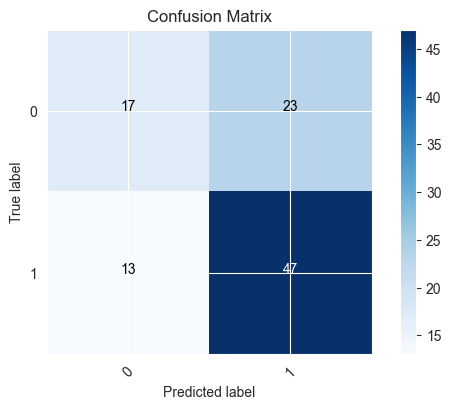

              precision    recall  f1-score   support

           0       0.57      0.42      0.49        40
           1       0.67      0.78      0.72        60

    accuracy                           0.64       100
   macro avg       0.62      0.60      0.60       100
weighted avg       0.63      0.64      0.63       100


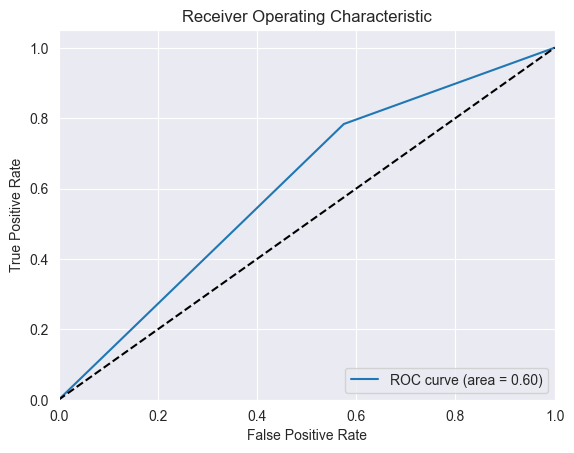

In [20]:
evaluate_each_results(results['true_labels'], results['predicted_labels'])

In [14]:
# Define the configurations for the experiments  
configurations = [  
    # Zero-shot  
    {  
        'template_type': 'zero_shot',  
        'template_text': prompts.template_zero_shot_only_comment,  
        'input_vars': ["comment", "start_task_context_prompt"],  
        'input_vars_values': {"start_task_context_prompt": prompts.start_task_context_prompt}  
    },  
    # Single-shot positive example  
    {  
        'template_type': 'single_shot_pos_example',  
        'template_text': prompts.template_single_shot_only_pos_comment,  
        'input_vars': ["comment", "start_task_context_prompt", "example_comment_pos"],  
        'input_vars_values': {"start_task_context_prompt": prompts.start_task_context_prompt,
                                "example_comment_pos": comments.comment_1_pos}
    },  
    # Single-shot negative example  
    {  
        'template_type': 'single_shot_neg_example',  
        'template_text': prompts.template_single_shot_only_neg_comment,  
        'input_vars': ["comment", "start_task_context_prompt", "example_comment_neg"],  
             'input_vars_values': {"start_task_context_prompt": prompts.start_task_context_prompt,
                                "example_comment_neg": comments.comment_1_neg}
    },  
    # Single-shot both examples  
    {  
        'template_type': 'single_shot_both_examples',  
        'template_text': prompts.template_single_shot_only_comment,  
        'input_vars': ["comment", "start_task_context_prompt", "example_comment_pos", "example_comment_neg"],  
        'input_vars_values': {"start_task_context_prompt": prompts.start_task_context_prompt,
                                "example_comment_pos": comments.comment_1_pos,
                                "example_comment_neg": comments.comment_1_neg}
    },  
    # Few-shot positive examples  
    {  
        'template_type': 'few_shot_pos_examples',  
        'template_text': prompts.template_few_shot_only_pos_comment,  
        'input_vars': ["comment", "start_task_context_prompt", "example_comment_1_pos", "example_comment_2_pos", 'example_comment_3_pos'],  
        'input_vars_values': {"start_task_context_prompt": prompts.start_task_context_prompt,
                                "example_comment_1_pos": comments.comment_1_pos,
                                "example_comment_2_pos": comments.comment_2_pos,
                                'example_comment_3_pos': comments.comment_3_pos}
    },  
    # Few-shot negative examples  
     {  
        'template_type': 'few_shot_neg_examples',  
        'template_text': prompts.template_few_shot_only_neg_comment,  
        'input_vars': ["comment", "start_task_context_prompt", "example_comment_1_neg", "example_comment_2_neg", 'example_comment_3_neg'],  
        'input_vars_values': {  
            "start_task_context_prompt": prompts.start_task_context_prompt,  
            "example_comment_1_neg": comments.comment_1_neg,  
            "example_comment_2_neg": comments.comment_2_neg,  
            'example_comment_3_neg': comments.comment_3_neg  
        }  
    },  
    # Few-shot both examples  
  {  
        'template_type': 'few_shot_examples',  
        'template_text': prompts.template_few_shot_only_comment,  
        'input_vars': ["comment", "start_task_context_prompt", "example_comment_1_pos", "example_comment_2_pos", 'example_comment_3_pos',
                       "example_comment_1_neg", "example_comment_2_neg", 'example_comment_3_neg'],  
        'input_vars_values': {
            "start_task_context_prompt": prompts.start_task_context_prompt,
            "example_comment_1_pos": comments.comment_1_pos,
            "example_comment_2_pos": comments.comment_2_pos,
            'example_comment_3_pos': comments.comment_3_pos,
            "example_comment_1_neg": comments.comment_1_neg,  
            "example_comment_2_neg": comments.comment_2_neg,  
            'example_comment_3_neg': comments.comment_3_neg
        }
  }
]


In [26]:
import json
# Assuming 'df' is the DataFrame with the data to evaluate  
num_records = 100  # Number of records to evaluate  
azure_deployment_name = 'gpt-35-turbo'  # Replace with your specific deployment name  
  
# Dictionary to store the results of all runs  
all_results = []  
  
# Iterate over all configurations and run the evaluation  
for config in configurations:  
    print(f"Running configuration: {config['template_type']}") 
    template_dict = {'template_type': config['template_type'], 'template_text': config['template_text']}
    result = run_evaluation(df, azure_deployment_name,
                            num_records,   
                            template_dict,   
                            config['input_vars'],   
                            config['input_vars_values'],  
                            verbose=True)  
    all_results.append(result)  
  
# Convert results to JSON and save to a file  
results_json = json.dumps(all_results, indent=4)
result_file_name = f'{azure_deployment_name}_evaluation_results.json'  
with open(result_file_name, 'w') as outfile:  
    outfile.write(results_json)  
  
print(f"All evaluations are complete and results are saved to {result_file_name}.")

Running configuration: zero_shot
Model initialized.


100it [00:23,  4.30it/s]


Predictions made.
Accuracy: 0.57
Precision: 0.6142207523770152
Recall: 0.57
Running configuration: single_shot_pos_example
Model initialized.


100it [00:21,  4.63it/s]


Predictions made.
Accuracy: 0.58
Precision: 0.7197368421052631
Recall: 0.58
Running configuration: single_shot_neg_example
Model initialized.


100it [00:22,  4.39it/s]


Predictions made.
Accuracy: 0.65
Precision: 0.6784423926134083
Recall: 0.65
Running configuration: single_shot_both_examples
Model initialized.


100it [00:21,  4.59it/s]


Predictions made.
Accuracy: 0.59
Precision: 0.6356345597354278
Recall: 0.59
Running configuration: few_shot_pos_examples
Model initialized.


100it [00:22,  4.51it/s]


Predictions made.
Accuracy: 0.57
Precision: 0.7139469226425749
Recall: 0.57
Running configuration: few_shot_neg_examples
Model initialized.


100it [00:22,  4.47it/s]


Predictions made.
Accuracy: 0.67
Precision: 0.6686843211433375
Recall: 0.67
Running configuration: few_shot_neg_examples
Model initialized.


100it [00:22,  4.36it/s]

Predictions made.
Accuracy: 0.61
Precision: 0.6734448734448734
Recall: 0.61
All evaluations are complete and results are saved to gpt-35-turbo_evaluation_results.json.


In [18]:
print(len(all_results))

7
